In [4]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2
import torch
from torch.distributions.categorical import Categorical
import matplotlib.pyplot as plt
import importlib 
import src.utils as utils
import json
import numpy as np
from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Inverse transform sampling

In [ ]:
lamb = 0.1
exp_dist = lamb*torch.exp(lamb*torch.arange(100))
exp_dist = torch.unsqueeze(exp_dist, 0)

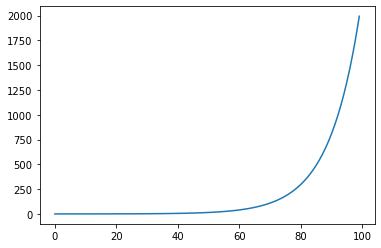

In [ ]:
plt.plot(torch.arange(100), exp_dist[0]);

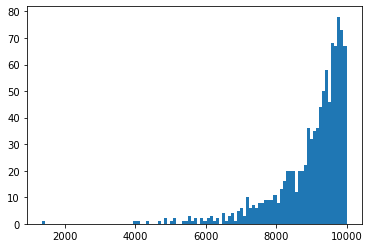

In [ ]:
dist = utils.sample_fine(1000, torch.arange(101).unsqueeze(0), exp_dist).detach()
a = torch.round(dist * 100)
plt.hist(a, 100);

In [ ]:
dist = Categorical(probs=exp_dist)

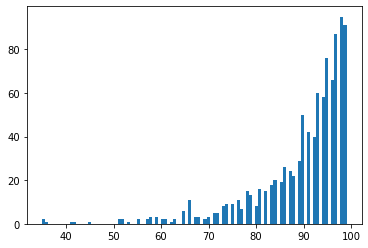

In [ ]:
plt.hist(dist.sample((1000,)).numpy(), 100);

In [ ]:
with open('./dataset/nerf_synthetic/chair/transforms_train.json') as f:
    data = json.load(f)
    
cm = torch.Tensor(data['frames'][0]['transform_matrix'])
w = 800
h = 800
f = (w/2)*(1/np.tan(data['camera_angle_x']/2))

In [ ]:
o, d = utils.get_rays(cm, f, h, w)

In [ ]:
oz = o[0,0].unsqueeze(0)
dz = d[0,0].unsqueeze(0)
a, b = utils.transform_to_ndc(oz, dz, 1, f, h, w)

tensor([[ 0.9426,  1.5231, -1.0000]])


In [ ]:
o[0][0]
torch.max(d)

tensor(0.6940)

In [ ]:
b[0]

tensor([-0.2208, -0.9157,  2.0000])

In [ ]:
a + 0.5*b

tensor([[0.3923, 0.7681, 0.0000]])

In [ ]:
from PIL import Image
import torchvision.transforms.functional as F

img = Image.open('dataset/nerf_synthetic/chair/train/r_0.png').convert('RGBA')
bkg = Image.new('RGBA', img.size, (255, 255, 255))
img = Image.alpha_composite(bkg, img).convert('RGB')
img = F.to_tensor(img)
img = img.reshape(3, -1).t()

In [ ]:
B = 4
t = 7
d = 3
ts = torch.rand(B, t)
os = torch.rand(B, d)
ds = torch.rand(B, d)

In [ ]:
ts[:,None,...].shape

torch.Size([4, 1, 7])

In [ ]:
(ts[...,None]*ds[:,None,:]).shape

torch.Size([4, 7, 3])

In [ ]:
importlib.reload(utils);
near = 3*torch.ones(B)
far = 5*torch.ones(B)
n = 5
utils.sample_coarse(B, n, near, far)

tensor([[3.2815, 3.7656, 3.8536, 4.3467, 4.8907],
        [3.3031, 3.4774, 3.9770, 4.2670, 4.9960],
        [3.0798, 3.5583, 3.8934, 4.3691, 4.7724],
        [3.1439, 3.6133, 4.1749, 4.4962, 4.7734]])

In [ ]:
import src.dataset as ds
from src.module import NeRFModule
from pathlib import Path
from src import utils
import numpy as np

dataset = ds.NeRFBlenderDataSet("val", Path("/ssd_scratch/cvit/ishaanshah/nerf_dataset/nerf_synthetic/lego/"), 0.1)

In [ ]:
o, d, c, n, f = dataset[0]
s = int(np.sqrt(o.shape[0]))
l = o.shape[0]

In [ ]:
model = NeRFModule.load_from_checkpoint("nerf/6mvi7n5f/checkpoints/epoch=132-step=83125.ckpt")

/home2/ishaanshah/anaconda3/envs/SemGCN/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `SSIM` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [ ]:
tc = utils.sample_coarse(6400, 64, n*torch.ones(6400), f*torch.ones(6400))

In [ ]:
cp, wp = utils.render(o, d, tc, model.model_coarse, 10, 4, 100, True)

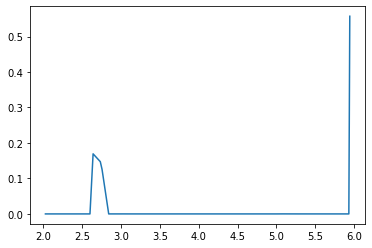

In [ ]:
plt.plot(tc[0], w[1].detach().numpy())

In [ ]:
torch.nonzero(c < .5)

tensor([[ 442,    2],
        [ 443,    2],
        [ 518,    2],
        ...,
        [5952,    1],
        [5952,    2],
        [5953,    2]])